In [1]:
import os

# os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex

Audited 6 packages in 1.51s


# Imports


In [3]:
import random
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall
from sklearnex import patch_sklearn
import warnings
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
from datasets import load_dataset

os.mkdir("reports")
patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'reports'

In [4]:
!nvidia-smi

Thu May  2 00:56:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             14W /  130W |     990MiB /   6144MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Active Learning


In [5]:
def active_learning(
    pool_x,
    pool_y,
    initial_x,
    initial_y,
    test_x,
    test_y,
    method,
    model,
    num_classes,
    class_names,
):
    learner = None
    cycles = 3
    acc = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":

        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            #             pool_x = pool_x.reshape(-1, 3, 32, 32)
            query_idx = np.random.choice(
                range(n_samples), size=n_instances, replace=False
            )
            X_query = pool_x[query_idx]
            return query_idx, X_query

        initial_x = initial_x.astype(np.float32)
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=random_sampling,
        )
    else:
        print("Invalid Input")
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, query_instance = learner.query(
            pool_x, n_instances=1
        )  # n_instances=100
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        # remove queried instance from pool_x
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(
            np.concatenate((initial_x, pool_x), axis=0),
            np.concatenate((initial_y, pool_y), axis=0),
        )
        print(f"Accuracy after query {cycle+1}: {model_accuracy:0.4f}")
        acc.append(model_accuracy)

        y_pred = learner.predict(test_x)
        # Initialize precision, recall, and F1 score metrics
        precision = Precision(task="multiclass", num_classes=num_classes)
        recall = Recall(task="multiclass", num_classes=num_classes)
        f1 = F1Score(task="multiclass", num_classes=num_classes)
        # Update the metrics with true and predicted labels
        precision.update(torch.tensor(y_pred), torch.tensor(test_y))
        recall.update(torch.tensor(y_pred), torch.tensor(test_y))
        f1.update(torch.tensor(y_pred), torch.tensor(test_y))
        # Compute the metrics
        precision_result.append(precision.compute())
        recall_result.append(recall.compute())
        f1_result.append(f1.compute())

    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    confusion_matrix.update(torch.tensor(y_pred), torch.tensor(test_y))
    confusion_matrix.compute()
    fig, ax = plot_confusion_matrix(
        conf_mat=confusion_matrix.compute().numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports/conf_mat_{method}_after_al.png")
    return acc, precision_result, recall_result, f1_result

# Data


In [6]:
imdb = load_dataset("stanfordnlp/imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
x_train = imdb["train"]["text"]
y_train = imdb["train"]["label"]
x_test = imdb["test"]["text"]
y_test = imdb["test"]["label"]

In [8]:
random_idx = random.sample(range(len(x_train)), 10000)
x_train = np.array(x_train)[random_idx]
y_train = np.array(y_train)[random_idx]

random_idx = random.sample(range(len(x_test)), 10000)
x_test = np.array(x_test)[random_idx]
y_test = np.array(y_test)[random_idx]

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000,), (10000,), (10000,), (10000,))

In [10]:
embed = hub.load(
    "/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2"
)

OSError: /kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2 does not exist.

In [ ]:
x_train_embeddings = embed(x_train)
x_test_embeddings = embed(x_test)

In [ ]:
x_train = x_train_embeddings.numpy()
x_test = x_test_embeddings.numpy()

In [ ]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(len(x_train) * percentage_without_labels)
num_samples_with_labels = len(x_train) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(x_train)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(x_train)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [ ]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((2000, 512), (2000,), (8000, 512), (8000,))

In [ ]:
x_train.shape

(10000, 512)

In [ ]:
clf = LogisticRegression()

In [ ]:
clf.fit(x_initial, y_initial)

INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU


LogisticRegression()

In [ ]:
clf.score(x_test, y_test)

INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU


0.8448

INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.util

Starting Active Learning with random_sampling method

Cycle: 1
Accuracy after query 1: 0.8501

Cycle: 2
Accuracy after query 2: 0.8501

Cycle: 3
Accuracy after query 3: 0.8497


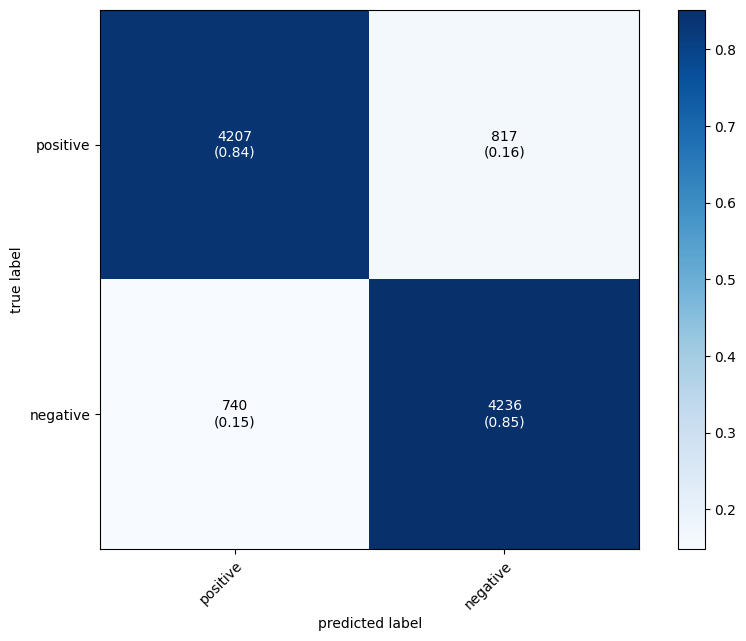

In [ ]:
(
    acc_random_sampling,
    precision_result_random_sampling,
    recall_result_random_sampling,
    f1_result_random_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "random_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklear

Starting Active Learning with uncertainty_sampling method

Cycle: 1
Accuracy after query 1: 0.8499

Cycle: 2
Accuracy after query 2: 0.8503

Cycle: 3


INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU


Accuracy after query 3: 0.8505


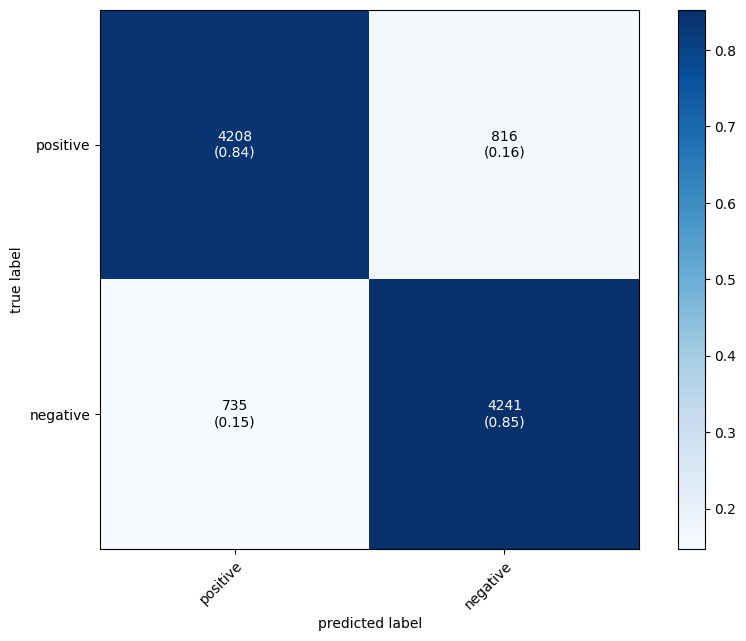

In [ ]:
(
    acc_uncertainty_sampling,
    precision_result_uncertainty_sampling,
    recall_result_uncertainty_sampling,
    f1_result_uncertainty_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "uncertainty_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklear

Starting Active Learning with margin_sampling method

Cycle: 1
Accuracy after query 1: 0.8537

Cycle: 2
Accuracy after query 2: 0.8542

Cycle: 3


INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU


Accuracy after query 3: 0.8543


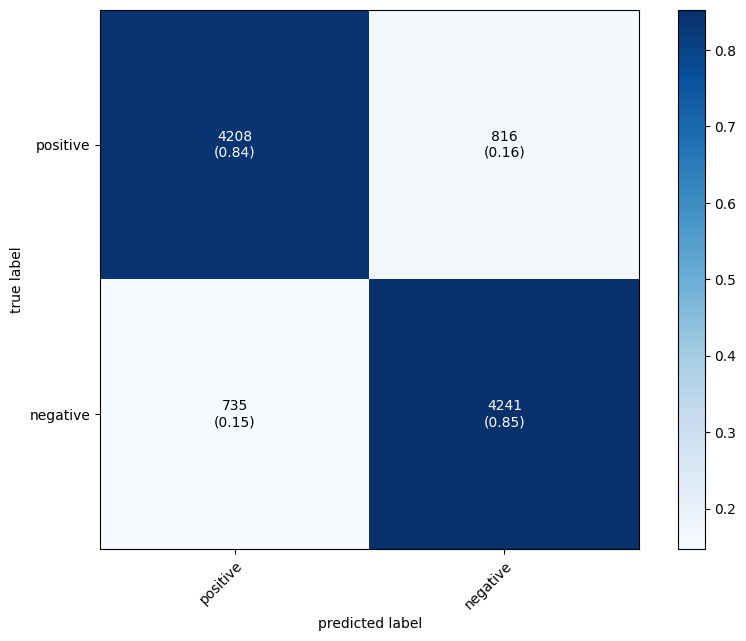

In [ ]:
(
    acc_margin_sampling,
    precision_result_margin_sampling,
    recall_result_margin_sampling,
    f1_result_margin_sampling,
) = active_learning(
    x_train,
    y_train,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "margin_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklear

Starting Active Learning with entropy_sampling method

Cycle: 1
Accuracy after query 1: 0.8542

Cycle: 2
Accuracy after query 2: 0.8541

Cycle: 3


INFO:sklearnex: sklearn.linear_model.LogisticRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU


Accuracy after query 3: 0.8548


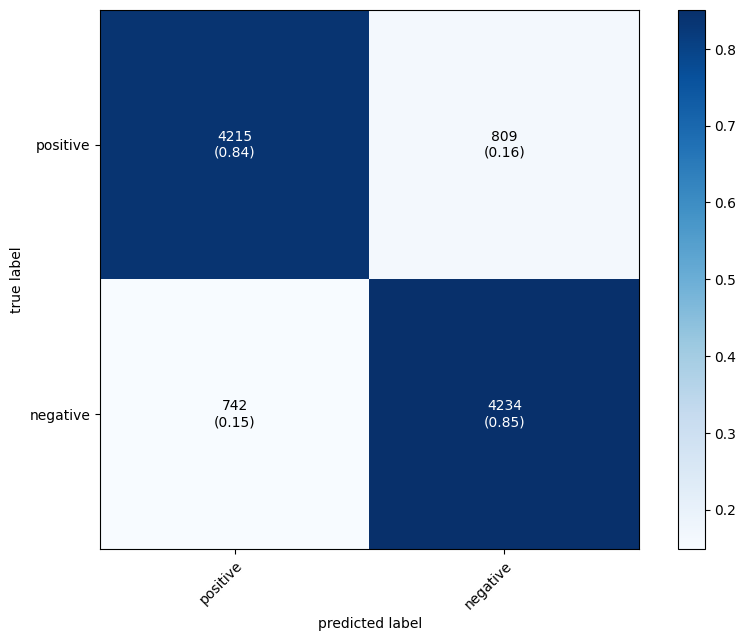

In [ ]:
(
    acc_entropy_sampling,
    precision_result_entropy_sampling,
    recall_result_entropy_sampling,
    f1_result_entropy_sampling,
) = active_learning(
    x_train,
    y_train,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "entropy_sampling",
    clf,
    2,
    ["positive", "negative"],
)

# Plot All Metrics


# Accuracy


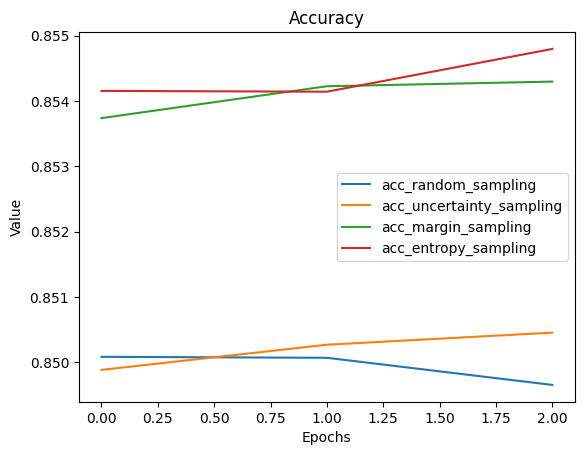

acc_random_sampling: 0.8496548964689407
acc_uncertainty_sampling: 0.8504551365409623
acc_margin_sampling: 0.8542969075602234
acc_entropy_sampling: 0.8547970325914812


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(acc_uncertainty_sampling, label="acc_uncertainty_sampling")
plt.plot(acc_margin_sampling, label="acc_margin_sampling")
plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/acc_nlp_model_after_al.png")

print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"acc_uncertainty_sampling: {acc_uncertainty_sampling[-1]}")
print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

# Precision


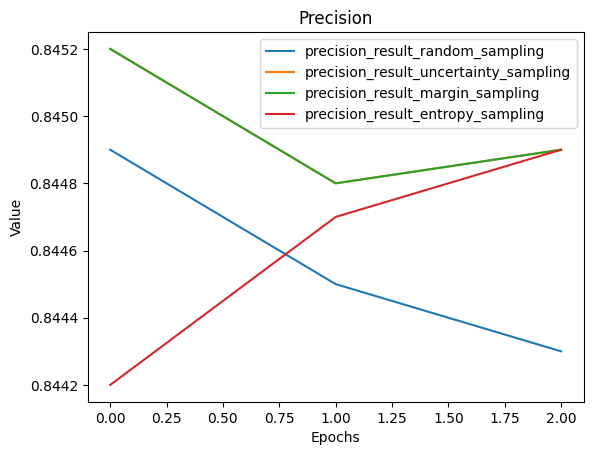

precision_result_random_sampling: 0.8442999720573425
precision_result_uncertainty_sampling: 0.8449000120162964
precision_result_margin_sampling: 0.8449000120162964
precision_result_entropy_sampling: 0.8449000120162964


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(
    precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling"
)
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/prec_nlp_model_after_al.png")

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(
    f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}"
)
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

# Recall


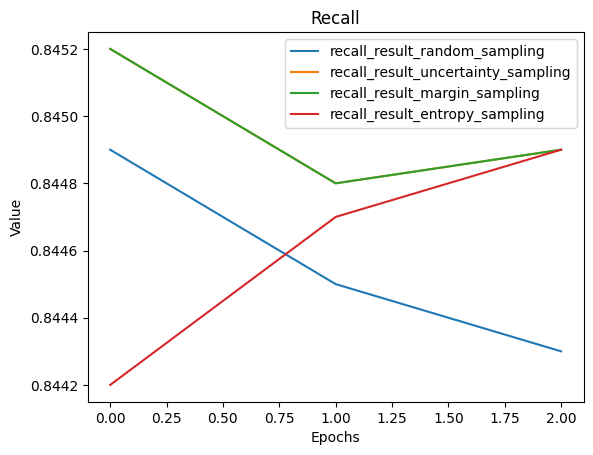

recall_result_random_sampling: 0.8442999720573425
recall_result_uncertainty_sampling: 0.8449000120162964
recall_result_margin_sampling: 0.8449000120162964
recall_result_entropy_sampling: 0.8449000120162964


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/recall_nlp_model_after_al.png")

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

# F1 Score


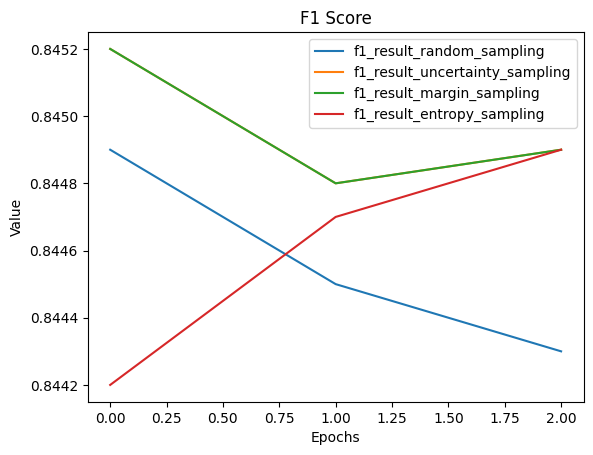

f1_result_random_sampling: 0.8442999720573425
f1_result_uncertainty_sampling: 0.8449000120162964
f1_result_margin_sampling: 0.8449000120162964
f1_result_entropy_sampling: 0.8449000120162964


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/f1_nlp_model_after_al.png")

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")

In [ ]:
import shutil

shutil.rmtree("/kaggle/working/data")
shutil.rmtree("/kaggle/working/models")